somewhere else, do:
```
git clone https://github.com/lsst/ip_diffim.git
cd ip_diffim
source ~/lsstsw/setup.csh
#setup -t b1898 ip_diffim
#setup -k -r .
setup -t b1898 -r .
scons opt=3 -j 4 lib python
```

then you will want to add `$HOME/lsstsw/miniconda/lib/python2.7/site-packages` to your `PYTHONPATH` in order to be able to import `joblib` and friends.

now edit and run the code in here.

In [1]:
import sys
from collections import namedtuple

import numpy as np

%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt

import matplotlib
matplotlib.style.use('ggplot')

import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)

import lmfit

from joblib import Parallel, delayed  
import multiprocessing

np.random.seed(666)

import pandas as pd
class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self,ob, size=50, height=120):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)

def display2dArray(arr, title='Data', showBars=True):
    img = plt.imshow(arr, origin='lower', interpolation='none', cmap='gray' )
    plt.title(title)
    if showBars: plt.colorbar(img, cmap='gray')

def displayImage(image, showMasks=True, showVariance=False, showPsf=False, showBars=True, isPsf=False):
    plt.figure(figsize=(8, 2.5))
    plt.subplot(1, 3, 1)
    ma = image.getMaskedImage().getArrays()
    display2dArray(ma[0], title='Data', showBars=showBars)
    if showMasks:
        plt.subplot(1, 3, 2)
        display2dArray(ma[1], title='Masks', showBars=showBars)
    if showVariance and not showPsf:
        plt.subplot(1, 3, 3)
        display2dArray(ma[2], title='Variance', showBars=showBars)
    if showPsf:
        plt.subplot(1, 3, 3)
        display2dArray(image.getPsf().computeImage().getArray(), title='PSF', showBars=showBars)

In [2]:
## LSST imports:
import lsst.utils.tests as tests
import lsst.daf.base as dafBase
#import lsst.afw.display.ds9 as ds9
import lsst.afw.image as afwImage
import lsst.afw.geom as afwGeom
import lsst.afw.table as afwTable
import lsst.afw.math as afwMath
import lsst.meas.algorithms as measAlg
import lsst.ip.diffim as ipDiffim

#### New: use `lsst.meas.base.tests.TestDataset` for generation of dipoles!

Need to do 
```
setup -t b1898 meas_base
```

100.0
2.0
1800.75


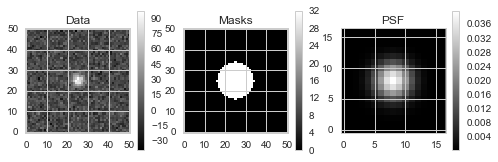

In [3]:
from lsst.meas.base.tests import TestDataset

def makeStarImage_lsst(w=51, h=51, xc=25, yc=25, flux=2500, psfSigma=2., noise=1.0):
    bbox = afwGeom.Box2I(afwGeom.Point2I(0,0), afwGeom.Point2I(w-1, h-1))
    dataset = TestDataset(bbox, psfSigma=psfSigma, threshold=1.)
    dataset.addSource(flux=flux, centroid=afwGeom.Point2D(xc, yc))
    exposure, catalog = dataset.realize(noise=noise, schema=TestDataset.makeMinimalSchema())
    return exposure, catalog

exposure, catalog = makeStarImage_lsst(flux=2500, noise=10.)
displayImage(exposure, showPsf=True)
print exposure.getMaskedImage().getArrays()[2].mean()
print exposure.getPsf().computeShape().getDeterminantRadius()
print exposure.getMaskedImage().getArrays()[0].sum()

See [here](http://lsst-web.ncsa.illinois.edu/doxygen/x_releases_Summer2012DoxyDoc/afw_mask_planes.html) for afw mask info.

```
def showMask(msk, msg="???"):
    print "%-15s" % msg, " ".join(sorted([str(x) for x in msk.getMaskPlaneDict().items()]))

>>> dm = dipole.getMaskedImage().getMask()
>>> showMask(dm)  ## mask "5" == 2**5 == 32 is "DETECTED", is set. 
```


Default planes are 
```
## ???   ('BAD', 0) ('CR', 3) ('DETECTED', 5) ('DETECTED_NEGATIVE', 6) ('EDGE', 4) ('INTRP', 2) ('NO_DATA', 8) ('RHL', 9) ('SAT', 1) ('SUSPECT', 7)
```

For detection, mask "5" == 2**5 == 32 is "DETECTED", is set. 

(51, 51)
200.0
100.0
100.0


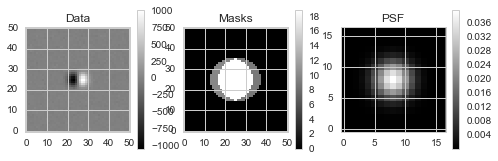

In [4]:
def makeDipoleImage_lsst(w=51, h=51, xcenPos=27., ycenPos=25., xcenNeg=23., ycenNeg=25., psfSigma=2., 
                         flux=30000., fluxNeg=None, noise=10.):
    posImage, posCatalog = makeStarImage_lsst(w, h, xcenPos, ycenPos, flux=flux, psfSigma=psfSigma, 
                                              noise=noise)
    if fluxNeg is None:
        fluxNeg = flux
    negImage, negCatalog = makeStarImage_lsst(w, h, xcenNeg, ycenNeg, flux=fluxNeg, psfSigma=psfSigma, 
                                              noise=noise)
    
    dipole = posImage.clone()
    di = dipole.getMaskedImage()
    di -= negImage.getMaskedImage()
    
    ## Carry through pos/neg detection masks to new planes in diffim image
    dm = di.getMask()
    posDetectedBits = posImage.getMaskedImage().getMask().getArray() == dm.getPlaneBitMask("DETECTED")
    negDetectedBits = negImage.getMaskedImage().getMask().getArray() == dm.getPlaneBitMask("DETECTED")
    pos_det = dm.addMaskPlane("DETECTED_POS") ## new mask plane -- this is different from "DETECTED"
    neg_det = dm.addMaskPlane("DETECTED_NEG") ## new mask plane -- this is different from "DETECTED_NEGATIVE"
    dma = dm.getArray()
    dma[:,:] = posDetectedBits * pos_det + negDetectedBits * neg_det  ## set the two custom mask planes to these masks
    return dipole, (posImage, posCatalog), (negImage, negCatalog)

dipole, (posImage, posCatalog), (negImage, negCatalog) = makeDipoleImage_lsst()
displayImage(dipole, showPsf=True)
print dipole.getMaskedImage().getArrays()[0].shape
print dipole.getMaskedImage().getArrays()[2].mean()
print posImage.getMaskedImage().getArrays()[2].mean()
print negImage.getMaskedImage().getArrays()[2].mean()

In [5]:
def detectDipoleSources(exposure, detectSigma=5.0, grow=1, verbose=False):
    # Detect positive and negative sources in the image. 
    # See meas_algorithms/python/lsst/meas/algorithms/detection.py (SourceDetectionConfig) for config params
    w, h = exposure.getWidth(), exposure.getHeight()
    psfSigma = exposure.getPsf().computeShape().getDeterminantRadius()

    config = measAlg.SourceDetectionConfig()
    config.thresholdPolarity = "both"
    config.reEstimateBackground = True
    config.nSigmaToGrow = psfSigma
    config.thresholdValue = detectSigma ##5.0   ## Default is 5 sigma, set via config.thresholdValue
    schema = afwTable.SourceTable.makeMinimalSchema()  
    task = measAlg.SourceDetectionTask(schema, config=config)
    table = afwTable.SourceTable.make(schema)
    results = task.makeSourceCatalog(table, exposure, sigma=psfSigma)

    if verbose:
        for fp in results.fpSets.positive.getFootprints():
            for pk in fp.getPeaks():
                print 'POS:', pk.getIx(), pk.getIy()
        for fp in results.fpSets.negative.getFootprints():
            for pk in fp.getPeaks():
                print 'NEG:', pk.getIx(), pk.getIy()

    # Merge them together
    #assert(len(results.sources) >= 2)
    fpSet = results.fpSets.positive
    fpSet.merge(results.fpSets.negative, grow, grow, False) ## note used to be tGrow=0, rGrow=0, but sometimes sources were not merged.
    sources = afwTable.SourceCatalog(table)
    fpSet.makeSources(sources)
    #assert(len(sources) >= 1)

    s = sources[0]    
    #assert(len(s.getFootprint().getPeaks()) == 2)        
    return s

FOOTPRINT CENTER: 25 28
FOOTPRINT CENTER: 25 22


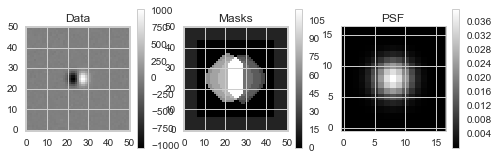

In [6]:
dipole, (posImage, posCatalog), (negImage, negCatalog) = makeDipoleImage_lsst()

s = detectDipoleSources(dipole, verbose=False)

for pk in s.getFootprint().getPeaks():
    print 'FOOTPRINT CENTER:', pk.getIy(), pk.getIx()

displayImage(dipole, showPsf=True)

In [7]:
## I think this is the meat of the ip_diffim code that runs the measurement. 
def measureDipole(s, exposure, dipoleCentroid):
    msConfig = ipDiffim.DipoleMeasurementConfig()
    schema = afwTable.SourceTable.makeMinimalSchema()
    schema.addField("centroid_x", type=float)
    schema.addField("centroid_y", type=float)
    schema.addField("centroid_flag", type='Flag')
    task = ipDiffim.DipoleMeasurementTask(schema, config=msConfig)
    measCat = afwTable.SourceCatalog(schema)
    measCat.defineCentroid("centroid")
    source = measCat.addNew()
    source.set("centroid_x", dipoleCentroid[0])
    source.set("centroid_y", dipoleCentroid[1])
    source.setFootprint(s.getFootprint())

    #print 'DIPOLE: ', source.get("classification_dipole") ## from ipDiffim.DipoleMeasurementTask._ClassificationFlag
    # Then run the default SFM task.  Results not checked
    task.run(measCat, exposure)
    return measCat[0] 

from collections import namedtuple
resultsOutput = namedtuple('resultsOutput', 
        #'inputCentroidX inputCentroidY inputSeparation inputRotation inputFlux inputPosCentroidX inputPosCentroidY inputNegCentroidX inputNegCentroidY psfFitPosCentroidX psfFitPosCentroidY psfFitNegCentroidX psfFitNegCentroidY psfFitPosFlux psfFitNegFlux psfFitCentroidX psfFitCentroidY psfFitOrientation psfFitSignaltoNoise')
        'psfFitPosCentroidX psfFitPosCentroidY psfFitNegCentroidX psfFitNegCentroidY psfFitPosFlux psfFitNegFlux psfFitCentroidX psfFitCentroidY psfFitOrientation psfFitSignaltoNoise')

def fitDipole_ipDiffim(exposure, sCat):    
    pks = sCat.getFootprint().getPeaks()
    pk1 = pks[0].getF() #)[::-1]  ## need to switch x,y ?? No.
    pk2 = pks[1].getF() #)[::-1]

    dipoleCentroid = (np.int(np.mean([pk1[0], pk2[0]])), np.int(np.mean([pk1[1], pk2[1]])))
    result = measureDipole(sCat, exposure, dipoleCentroid=dipoleCentroid)
    
    ## provides (S/N, position, orientation) of measured dipoles
    dpAnalysis = ipDiffim.DipoleAnalysis()
    sn, centroid, orientation = dpAnalysis(result)

    #rotAngRad = rotAngle / 180. * np.pi
    #xp, yp = xc + separation/2. * np.cos(rotAngRad), yc + separation/2. * np.sin(rotAngRad)
    #xn, yn = xc - separation/2. * np.cos(rotAngRad), yc - separation/2. * np.sin(rotAngRad)

    out = resultsOutput(##xc, yc, separation, rotAngle, flux, xp, yp, xn, yn, 
        result.get("ip_diffim_PsfDipoleFlux_pos_centroid_x"), result.get("ip_diffim_PsfDipoleFlux_pos_centroid_y"),
        result.get("ip_diffim_PsfDipoleFlux_neg_centroid_x"), result.get("ip_diffim_PsfDipoleFlux_neg_centroid_y"),
        result.get("ip_diffim_PsfDipoleFlux_pos_flux"), result.get("ip_diffim_PsfDipoleFlux_neg_flux"),
        centroid.getX(), centroid.getY(), orientation, sn)
    return out

In [8]:
def dipoleFunc(x, flux, xcenPos, ycenPos, xcenNeg, ycenNeg, fluxNeg=None, 
               **kwargs):
    """
    Dipole based on image's psf. Image is passed as kwargs['diffim']
    dipoleFunc(x, flux, xcenPos, ycenPos, xcenNeg, ycenNeg, fluxNeg)
    """
    diffim = kwargs.get('diffim')
    psf = diffim.getPsf()
    
    if fluxNeg is None:
        fluxNeg = flux

    w, h = x[0].shape
    
    p_pos = psf.computeImage(afwGeom.Point2D(xcenPos, ycenPos)).convertF()
    p_pos_sum = np.sum(p_pos.getArray())
    p_pos *= (flux/p_pos_sum)
    p_neg = psf.computeImage(afwGeom.Point2D(xcenNeg, ycenNeg)).convertF()
    p_neg_sum = np.sum(p_neg.getArray())
    p_neg *= (fluxNeg/p_neg_sum)
    #print p_pos_sum, p_neg_sum
    
    box = afwGeom.BoxI(afwGeom.PointI(0, 0), afwGeom.ExtentI(w, h))
    posIm = afwImage.ImageF(box)
    negIm = posIm.clone()
    dipole = posIm.clone()
    subim = afwImage.ImageF(posIm, p_pos.getBBox(), afwImage.LOCAL)
    subim += p_pos
    subim = afwImage.ImageF(negIm, p_neg.getBBox(), afwImage.LOCAL)
    subim += p_neg

## Running these 4 lines is faster ...
    subim = afwImage.ImageF(dipole, p_pos.getBBox(), afwImage.LOCAL)
    subim += p_pos
    subim = afwImage.ImageF(dipole, p_neg.getBBox(), afwImage.LOCAL)
    subim -= p_neg
    ## ... than running these 2 lines
    #dipole += posIm
    #dipole -= negIm
    
    zout = dipole.getArray()
    zout = np.append([zout], [posIm.getArray(), negIm.getArray()], axis=0)
    return zout

def fitDipole(exposure, cenPos=None, cenNeg=None, tol=1e-7, rel_weight=0.1, verbose=False, display=False):
    """fitDipole(z, psfWidth=2., verbose=False, display=False, cenPos=None, cenNeg=None))
        Starting centroids may be provided as tuple/array coordinates of centroids of positive and negative lobes.
        If these are None, then assume they are the max/min of the stamp.
    """
    diffim, posImage, negImage = exposure    ## assume exposure is actually a tuple here.
    z = diffim.getMaskedImage().getArrays()[0] ## allow passing of just diffim (1-length tuple)
    z = np.append([z], [posImage.getMaskedImage().getArrays()[0], 
                        negImage.getMaskedImage().getArrays()[0]], axis=0)
        
    w, h = diffim.getWidth(), diffim.getHeight()
    psfSigma = diffim.getPsf().computeShape().getDeterminantRadius()
        
    gmod = lmfit.Model(dipoleFunc, verbose=verbose)

    ## For close/faint dipoles the starting locs (min/max) might be way off, let's help them a bit.
    ## First assume dipole is not separated by 3*psfSigma. This may be too small. Let's try 5 instead.
    centroidRange = psfSigma * 5.
    if cenPos is None:
        if rel_weight > 0.:
            cenPos = np.array(np.unravel_index(np.argmax(z[1,:]), (w,h)))
        else:
            cenPos = np.array(np.unravel_index(np.argmax(z[0,:]), (w,h)))
        
    ## Note - this may be a cheat to assume the dipole is centered in center of the stamp.
    if np.sum(np.sqrt((np.array(cenPos) - np.array([w/2, h/2]))**2.)) > centroidRange:
        cenPos = np.array([w/2., h/2.])
        
    if cenNeg is None:
        if rel_weight > 0.:
            cenNeg = np.array(np.unravel_index(np.argmin(z[1,:]), (w,h)))
        else:
            cenNeg = np.array(np.unravel_index(np.argmin(z[0,:]), (w,h)))

    if np.sum(np.sqrt((np.array(cenNeg) - np.array([w/2, h/2]))**2.)) > centroidRange:
        cenNeg = np.array([w/2., h/2.])

    ## parameter hints/constraints: https://lmfit.github.io/lmfit-py/model.html#model-param-hints-section
    gmod.set_param_hint('xcenPos', value=cenPos[0], min=cenPos[0]-centroidRange, max=cenPos[0]+centroidRange)
    gmod.set_param_hint('ycenPos', value=cenPos[1], min=cenPos[1]-centroidRange, max=cenPos[1]+centroidRange)
    gmod.set_param_hint('xcenNeg', value=cenNeg[0], min=cenNeg[0]-centroidRange, max=cenNeg[0]+centroidRange)
    gmod.set_param_hint('ycenNeg', value=cenNeg[1], min=cenNeg[1]-centroidRange, max=cenNeg[1]+centroidRange)

    ## TBD: if this actually is what we end up using, then we can't sum over the entier image. 
    ## Need to use a localized region/footprint and know the local background from the image?.
    if rel_weight > 0.:
        startingFlux = (z[1,:] - np.median(z[1,:])).sum()   ## subtract the background
    else:
        startingFlux = (np.abs(z[0,:]) - np.median(z[0,:])).sum() / 2.   ## use just the dipole for an estimate. Remove the background

    gmod.set_param_hint('flux', value=startingFlux, min=0.1) #, max=startingFlux * 2.)  ## TBD: higher flux limit? 
    gmod.set_param_hint('fluxNeg', value=startingFlux, min=0.1) #, max=startingFlux * 2.)  ## TBD: higher flux limit? 
    
    ## Fixed parameters (dont fit for them):
    #gmod.set_param_hint('exposure', value=exposure, vary=False)

    y, x = np.mgrid[:w, :h]
    in_x = np.array([x, y])
    
    ## TBD: weight the data by 1/variance
    # weights = 1.0/np.sqrt(np.abs(z))+1.0
    ## Weight the "pre-subtraction" planes by rel_weight (relative to the actual diffim plane)
    weights = np.array([np.ones_like(z[0,:]), np.ones_like(z[0,:])*rel_weight, np.ones_like(z[0,:])*rel_weight])
    
    result = gmod.fit(z, weights=weights,
                      x=in_x, flux=startingFlux, fluxNeg=startingFlux, 
                      xcenPos=cenPos[0], ycenPos=cenPos[1], 
                      xcenNeg=cenNeg[0], ycenNeg=cenNeg[1], verbose=verbose, #) #, sig1=1., sig2=2.)
                      ## default fit method -- levenberg-marquardt ('leastsq')
                      fit_kws={'ftol':tol, 'xtol':tol, 'gtol':tol},
                      diffim=diffim
                     )  
                      #method='nelder',
                      #fit_kws={'tol':tol})
    
    if verbose: 
        print result.fit_report(show_correl=False) 
        ## This is how to get confidence intervals out, see here: https://lmfit.github.io/lmfit-py/confidence.html and 
        ##    here: http://cars9.uchicago.edu/software/python/lmfit/model.html
        ## Note this calc takes a long time (longer than the fit!)
        print result.ci_report()

    if display:
        plt.figure(figsize=(8, 2.5))
        plt.subplot(1, 3, 2)
        display2dArray(result.best_fit[0,:], 'Model', True)
        plt.subplot(1, 3, 3)
        display2dArray(z[0,:] - result.best_fit[0,:], 'Residual', True)
        
    return result

def fitDipole_new(exposure, sCat, tol=1e-7, rel_weight=0.1, return_fitObj=False, 
                  verbose=False, display=False):
    #from collections import namedtuple
    #resultsOutput = namedtuple('resultsOutput', 
    #    'inputCentroidX inputCentroidY inputSeparation inputRotation inputFlux inputPosCentroidX inputPosCentroidY inputNegCentroidX inputNegCentroidY psfFitPosCentroidX psfFitPosCentroidY psfFitNegCentroidX psfFitNegCentroidY psfFitPosFlux psfFitNegFlux psfFitCentroidX psfFitCentroidY psfFitOrientation psfFitSignaltoNoise')

    pks = sCat.getFootprint().getPeaks()
    pk1 = pks[0].getF() #)[::-1]  ## need to switch x,y ?? No.
    pk2 = pks[1].getF() #)[::-1]

    result = fitDipole(exposure, cenPos=pk1, cenNeg=pk2, rel_weight=rel_weight, 
                       tol=tol, verbose=verbose, display=display)

    #rotAngRad = rotAngle / 180. * np.pi
    #xp, yp = xc + separation/2. * np.cos(rotAngRad), yc + separation/2. * np.sin(rotAngRad)
    #xn, yn = xc - separation/2. * np.cos(rotAngRad), yc - separation/2. * np.sin(rotAngRad)
    results = result.best_values
    
    centroid = ((results['xcenPos']+results['xcenNeg'])/2., (results['ycenPos']+results['ycenNeg'])/2.)
    dx, dy = results['xcenPos']-results['xcenNeg'], results['ycenPos']-results['ycenNeg']
    angle = np.arctan2(dy, dx) / np.pi * 180.   ## convert to degrees, or keep as rad?

    fluxVal, fluxErr = result.params['flux'].value, result.params['flux'].stderr
    fluxValNeg, fluxErrNeg = result.params['fluxNeg'].value, result.params['fluxNeg'].stderr
    signalToNoise = np.sqrt((fluxVal/fluxErr)**2 + (fluxValNeg/fluxErrNeg)**2) ## This is from DipoleAnalysis code
        
    out = resultsOutput(##xxc, yc, separation, rotAngle, flux, xp, yp, xn, yn, 
                        results['xcenPos'], results['ycenPos'], results['xcenNeg'], results['ycenNeg'],
                        fluxVal, -fluxValNeg, centroid[0], centroid[1], angle, signalToNoise)

    if not return_fitObj: 
        return out #.best_values
    return out, result

51 51
(3, 51, 51)


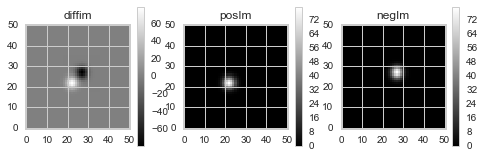

In [9]:
diffim, (posImage, posCatalog), (negImage, negCatalog) = makeDipoleImage_lsst(flux=2000)
w, h = diffim.getWidth(), diffim.getHeight()
print w, h
y, x = np.mgrid[:w, :h]
in_x = np.array([x, y])

arr = dipoleFunc(in_x, flux=2000., xcenPos=22., ycenPos=22., xcenNeg=27., ycenNeg=27., 
                 fluxNeg=None, diffim=diffim)
print arr.shape
plt.figure(figsize=(8, 2.5))
plt.subplot(1, 3, 1)
display2dArray(arr[0,:], title='diffim')
plt.subplot(1, 3, 2)
display2dArray(arr[1,:], title='posIm')
plt.subplot(1, 3, 3)
display2dArray(arr[2,:], title='negIm')

 - Adding parameter for hint "xcenPos"
 - Adding parameter for hint "ycenPos"
 - Adding parameter for hint "xcenNeg"
 - Adding parameter for hint "ycenNeg"
 - Adding parameter for hint "flux"
 - Adding parameter for hint "fluxNeg"
 - Adding parameter "flux"
 - Adding parameter "xcenPos"
 - Adding parameter "ycenPos"
 - Adding parameter "xcenNeg"
 - Adding parameter "ycenNeg"
 - Adding parameter "fluxNeg"
[[Model]]
    Model(dipoleFunc)
[[Fit Statistics]]
    # function evals   = 51
    # data points      = 7803
    # variables        = 6
    chi-square         = 495786.479
    reduced chi-square = 63.587
[[Variables]]
    xcenPos:   26.9898999 +/- 0.136756 (0.51%) (init= 28)
    ycenPos:   24.8306597 +/- 0.086356 (0.35%) (init= 25)
    xcenNeg:   22.9351751 +/- 0.134283 (0.59%) (init= 22)
    ycenNeg:   24.9887243 +/- 0.085993 (0.34%) (init= 25)
    flux:      1990.17884 +/- 92.15798 (4.63%) (init= 1272.744)
    fluxNeg:   2029.39176 +/- 91.81951 (4.52%) (init= 1272.744)

            9

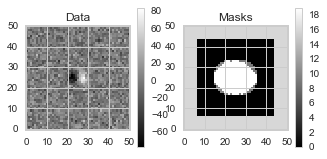

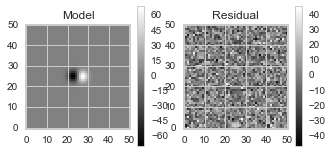

In [12]:
dipole, (posImage, posCatalog), (negImage, negCatalog) = makeDipoleImage_lsst(flux=2000)
displayImage(dipole)
s = detectDipoleSources(dipole, verbose=False)
result = fitDipole_new((dipole, posImage, negImage), s, verbose=True, rel_weight=0.05, display=True)
print '\n', result
result = fitDipole_new((dipole, posImage, negImage), s, verbose=False, rel_weight=0., display=False)
print result

In [13]:
result = fitDipole_ipDiffim(exposure=dipole, sCat=s)
print result
%timeit result = fitDipole_ipDiffim(exposure=dipole, sCat=s)

resultsOutput(psfFitPosCentroidX=26.98640402609665, psfFitPosCentroidY=24.82932801938738, psfFitNegCentroidX=22.937198820272208, psfFitNegCentroidY=24.990318910471956, psfFitPosFlux=1991.4058673446582, psfFitNegFlux=-2031.2896754748526, psfFitCentroidX=24.96180142318443, psfFitCentroidY=24.909823464929666, psfFitOrientation=1.61053 rad, psfFitSignaltoNoise=17.248522326914411)
10 loops, best of 3: 47.6 ms per loop


resultsOutput(psfFitPosCentroidX=26.988085363366217, psfFitPosCentroidY=24.830626750479084, psfFitNegCentroidX=22.937551986932711, psfFitNegCentroidY=24.990568908143672, psfFitPosFlux=1992.4986473757322, psfFitNegFlux=-2030.7239375854326, psfFitCentroidX=24.962818675149464, psfFitCentroidY=24.910597829311378, psfFitOrientation=-2.2612459550581656, psfFitSignaltoNoise=31.473039003799244)
10 loops, best of 3: 24.7 ms per loop
100 loops, best of 3: 13.3 ms per loop


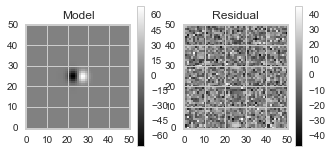

In [14]:
result = fitDipole_new((dipole, posImage, negImage), s, verbose=False, display=True)
print result
#%timeit fitDipole_new((dipole, posImage, negImage), s, verbose=False, rel_weight=0., display=False)  ## test the timings of new vs. old
%timeit fitDipole_new((dipole, posImage, negImage), s, verbose=False, display=False)
%timeit fitDipole_new((dipole, posImage, negImage), s, tol=1e-3, verbose=False, display=False)

In [15]:
resultsOutput2 = namedtuple('resultsOutput2',
    ['inputCentroidX', 'inputCentroidY', 'inputSeparation', 'inputRotation', 'inputFlux', 'inputPosCentroidX',
     'inputPosCentroidY', 'inputNegCentroidX', 'inputNegCentroidY', 'psfFitPosCentroidX', 'psfFitPosCentroidY',
     'psfFitNegCentroidX', 'psfFitNegCentroidY', 'psfFitPosFlux', 'psfFitNegFlux', 'psfFitCentroidX', 
     'psfFitCentroidY', 'psfFitOrientation', 'psfFitSignaltoNoise'])

def genDipoleAndFitBothWays(w=51, h=51, xc=25., yc=25., separation=2., rotAngle=324., psfSigma=2., 
                         flux=30000., noise=10., rel_weight=0.1, tol=1e-7, verbose=False, display=False):

    rotAngRad = rotAngle / 180. * np.pi
    sep = separation / 2.
    xcenPos, ycenPos = xc+sep*np.cos(rotAngRad), yc+sep*np.sin(rotAngRad)
    xcenNeg, ycenNeg = xc-sep*np.cos(rotAngRad), yc-sep*np.sin(rotAngRad)
    
    dipole, (posImage, posCatalog), (negImage, negCatalog) = \
        makeDipoleImage_lsst(w=w, h=h, xcenPos=xcenPos, ycenPos=ycenPos, \
                             xcenNeg=xcenNeg, ycenNeg=ycenNeg, \
                             psfSigma=psfSigma, flux=flux, noise=noise)

    resultNA = resultsOutput2(xc, yc, separation, rotAngle, flux, xcenPos, ycenPos, xcenNeg, ycenNeg,
                              np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan)

    result1 = result2 = resultNA
    s = None

    try:
        s = detectDipoleSources(dipole, verbose=False)
    except:
        return {'old': result2, 'new': result1, 'dipole': dipole}
    
    try:
        r1 = fitDipole_ipDiffim(exposure=dipole, sCat=s)
        result1 = resultsOutput2(xc, yc, separation, rotAngle, flux, xcenPos, ycenPos, xcenNeg, ycenNeg,
                            r1.psfFitPosCentroidX, r1.psfFitPosCentroidY, r1.psfFitNegCentroidX,
                            r1.psfFitNegCentroidY, r1.psfFitPosFlux, r1.psfFitNegFlux, r1.psfFitCentroidX,
                            r1.psfFitCentroidY, r1.psfFitOrientation, r1.psfFitSignaltoNoise)
    except:
        pass
    
    try:
        r2 = fitDipole_new((dipole, posImage, negImage), s, rel_weight=rel_weight,
                           verbose=False, display=False)
        result2 = resultsOutput2(xc, yc, separation, rotAngle, flux, xcenPos, ycenPos, xcenNeg, ycenNeg,
                            r2.psfFitPosCentroidX, r2.psfFitPosCentroidY, r2.psfFitNegCentroidX,
                            r2.psfFitNegCentroidY, r2.psfFitPosFlux, r2.psfFitNegFlux, r1.psfFitCentroidX,
                            r2.psfFitCentroidY, r2.psfFitOrientation, r2.psfFitSignaltoNoise)
    except:
        pass

    return {'old': result1, 'new': result2, 'dipole': dipole}

resultsOutput2(inputCentroidX=25.0, inputCentroidY=25.0, inputSeparation=2.0, inputRotation=324.0, inputFlux=1000.0, inputPosCentroidX=25.809016994374947, inputPosCentroidY=24.412214747707527, inputNegCentroidX=24.190983005625053, inputNegCentroidY=25.587785252292473, psfFitPosCentroidX=25.762325640773167, psfFitPosCentroidY=24.378418076068467, psfFitNegCentroidX=24.073861492192265, psfFitNegCentroidY=25.532582912873135, psfFitPosFlux=959.37195999935, psfFitNegFlux=-980.1508382734954, psfFitCentroidX=24.918093566482717, psfFitCentroidY=24.9555004944708, psfFitOrientation=2.1704 rad, psfFitSignaltoNoise=11.904270817452266)
resultsOutput2(inputCentroidX=25.0, inputCentroidY=25.0, inputSeparation=2.0, inputRotation=324.0, inputFlux=1000.0, inputPosCentroidX=25.809016994374947, inputPosCentroidY=24.412214747707527, inputNegCentroidX=24.190983005625053, inputNegCentroidY=25.587785252292473, psfFitPosCentroidX=25.741181464814893, psfFitPosCentroidY=24.395286450091699, psfFitNegCentroidX=24.0

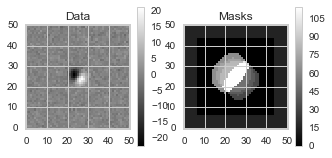

In [16]:
result = genDipoleAndFitBothWays(w=51, h=51, xc=25., yc=25., separation=2., rotAngle=324., psfSigma=2., 
                         flux=1000., noise=1., rel_weight=0.1, verbose=False, display=True)
print result['old']
print result['new']
displayImage(result['dipole'])

### First test dipoles of varying separation (same orientation, same flux)

In [19]:
## Is there an easier way to do this (generate named tuple from function variable names)?
varNames = genDipoleAndFitBothWays.__code__.co_varnames[:genDipoleAndFitBothWays.__code__.co_argcount]
varTuple = namedtuple("varTuple", varNames)

#orientations = np.arange(0.0, 360.0, 36.0)
separations = np.arange(0.2, 5.0, 0.2)[::-1]
n_reps = 100

inputs = [varTuple(w=51, h=51, xc=25., yc=25., psfSigma=2.0, separation=sep, rotAngle=0., \
                   flux=1000., noise=1., tol=1e-3, rel_weight=0.1, verbose=False, display=False) \
          for i in xrange(n_reps) for sep in separations]
print len(inputs)

def processInput(i):
    output = genDipoleAndFitBothWays(w=i.w, h=i.h, xc=i.xc, yc=i.yc, psfSigma=i.psfSigma,
                                     separation=i.separation, rotAngle=i.rotAngle, flux=i.flux, 
                                     noise=i.noise, tol=i.tol, rel_weight=i.rel_weight, verbose=False, display=False)
    if output['new'] is not None:
        output['new'] = output['new']._asdict()
    if output['old'] is not None:
        output['old'] = output['old']._asdict()
    return output

num_cores = multiprocessing.cpu_count() / 2
results = Parallel(n_jobs=num_cores)(delayed(processInput)(i) for i in inputs)
#results = [processInput(i) for i in inputs]

2400


(22, 28)

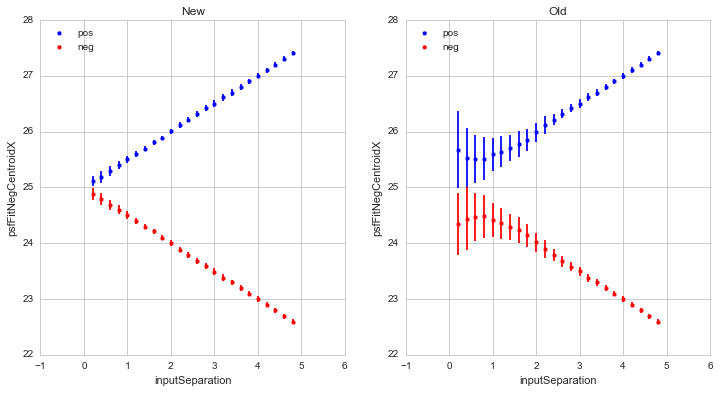

In [20]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
fig, axes = plt.subplots(nrows=1, ncols=2)

df = pd.DataFrame([res['new'] for res in results])
tmp_df = df.groupby('inputSeparation').mean()
tmp_df['inputSeparation'] = tmp_df.index.values
tmp_df2 = df.groupby('inputSeparation').std() * 1.
ax = tmp_df.plot(x='inputSeparation', y='psfFitPosCentroidX', kind='scatter', yerr=tmp_df2['psfFitPosCentroidX'], color='blue', label='pos', ax=axes[0])
tmp_df.plot(x='inputSeparation', y='psfFitNegCentroidX', kind='scatter', yerr=tmp_df2['psfFitNegCentroidX'], color='red', label='neg', ax=ax)

df = pd.DataFrame([res['old'] for res in results])
tmp_df = df.groupby('inputSeparation').mean()
tmp_df['inputSeparation'] = tmp_df.index.values
tmp_df2 = df.groupby('inputSeparation').std() * 1.
ax = tmp_df.plot(x='inputSeparation', y='psfFitPosCentroidX', kind='scatter', yerr=tmp_df2['psfFitPosCentroidX'], color='blue', label='pos', ax=axes[1])
tmp_df.plot(x='inputSeparation', y='psfFitNegCentroidX', kind='scatter', yerr=tmp_df2['psfFitNegCentroidX'], color='red', label='neg', ax=ax)

axes[0].set_title('New')
axes[0].set_ylim([22,28])
axes[1].set_title('Old')
axes[0].set_ylim([22,28])

(70, 110)

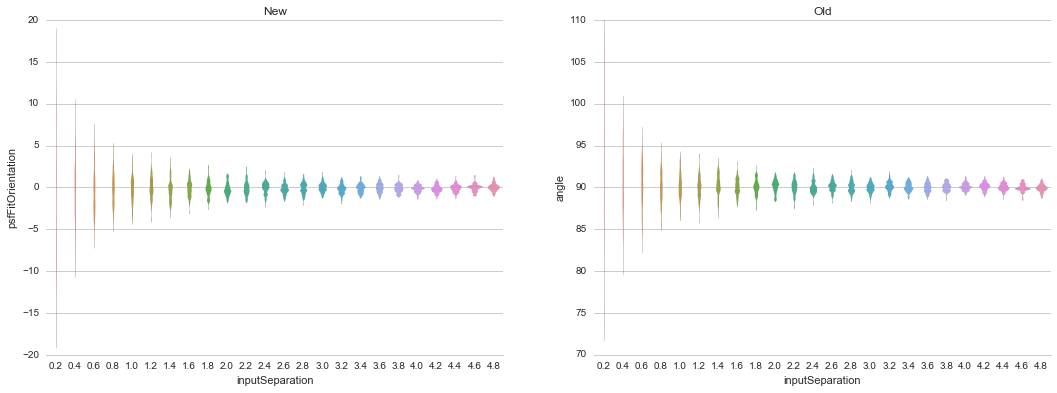

In [21]:
matplotlib.rcParams['figure.figsize'] = (18.0, 6.0)
fig, axes = plt.subplots(nrows=1, ncols=2)

df = pd.DataFrame([res['new'] for res in results])
sns.violinplot(x="inputSeparation", y="psfFitOrientation", data=df, inner="quart", cut=True, linewidth=0.1, bw=0.2, ax=axes[0])
sns.despine(left=True)

df = pd.DataFrame([res['old'] for res in results])
df['angle'] = pd.Series([float(i * 180. / np.pi) for i in df.psfFitOrientation])
sns.violinplot(x="inputSeparation", y="angle", data=df, inner="quart", cut=True, linewidth=0.1, bw=0.2, ax=axes[1])
sns.despine(left=True)

axes[0].set_title('New')
axes[0].set_ylim([-20,20])
axes[1].set_title('Old')
axes[1].set_ylim([70,110])

(0, 5)

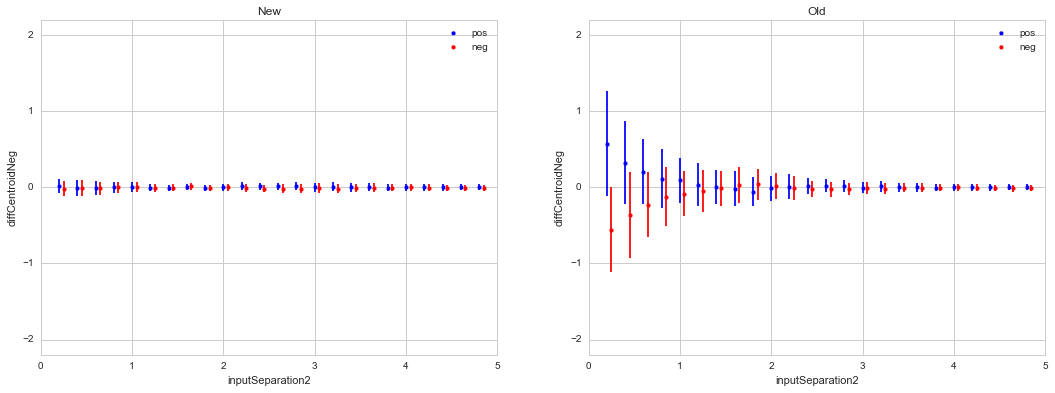

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=2)

df = pd.DataFrame([res['new'] for res in results])
df['diffCentroidPos'] = df.psfFitPosCentroidX - df.inputPosCentroidX
df['diffCentroidNeg'] = df.psfFitNegCentroidX - df.inputNegCentroidX
df['inputSeparation2'] = df.inputSeparation + 0.05
tmp_df = df.groupby('inputSeparation').mean()
tmp_df['inputSeparation'] = tmp_df.index.values
tmp_df2 = df.groupby('inputSeparation').std() * 1.
ax = tmp_df.plot(x='inputSeparation', y='diffCentroidPos', kind='scatter', yerr=tmp_df2['diffCentroidPos'], color='blue', label='pos', ax=axes[0])
tmp_df.plot(x='inputSeparation2', y='diffCentroidNeg', kind='scatter', yerr=tmp_df2['diffCentroidNeg'], color='red', label='neg', ax=ax)

df = pd.DataFrame([res['old'] for res in results])
df['diffCentroidPos'] = df.psfFitPosCentroidX - df.inputPosCentroidX
df['diffCentroidNeg'] = df.psfFitNegCentroidX - df.inputNegCentroidX
df['inputSeparation2'] = df.inputSeparation + 0.05
tmp_df = df.groupby('inputSeparation').mean()
tmp_df['inputSeparation'] = tmp_df.index.values
tmp_df2 = df.groupby('inputSeparation').std() * 1.
ax = tmp_df.plot(x='inputSeparation', y='diffCentroidPos', kind='scatter', yerr=tmp_df2['diffCentroidPos'], color='blue', label='pos', ax=axes[1])
tmp_df.plot(x='inputSeparation2', y='diffCentroidNeg', kind='scatter', yerr=tmp_df2['diffCentroidNeg'], color='red', label='neg', ax=ax)

axes[0].set_title('New')
axes[0].set_ylim([-2.2,2.2]); axes[0].set_xlim([0,5])
axes[1].set_title('Old')
axes[1].set_ylim([-2.2,2.2]); axes[1].set_xlim([0,5])

(-8000, 8000)

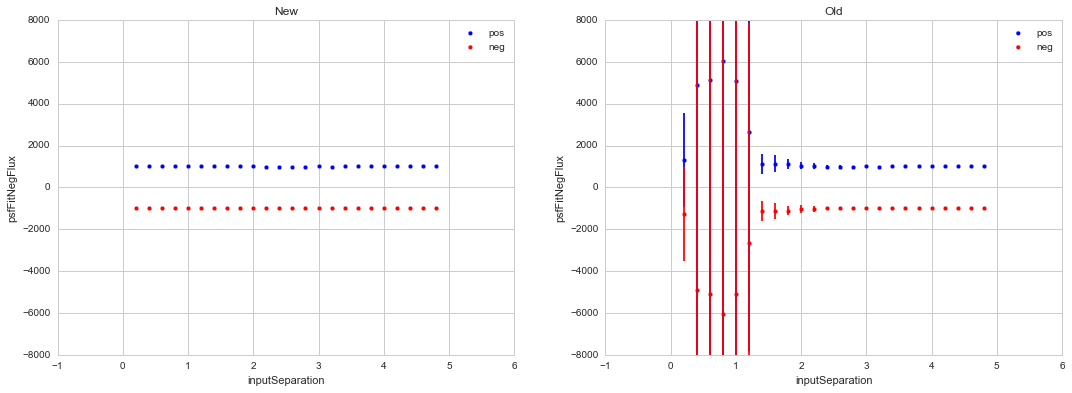

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=2)

df = pd.DataFrame([res['new'] for res in results])
tmp_df = df.groupby('inputSeparation').mean()
tmp_df['inputSeparation'] = tmp_df.index.values
tmp_df2 = df.groupby('inputSeparation').std() * 1.
ax = tmp_df.plot(x='inputSeparation', y='psfFitPosFlux', kind='scatter', yerr=tmp_df2['psfFitPosFlux'], color='blue', label='pos', ax=axes[0])
tmp_df.plot(x='inputSeparation', y='psfFitNegFlux', kind='scatter', yerr=tmp_df2['psfFitNegFlux'], color='red', label='neg', ax=ax)

df = pd.DataFrame([res['old'] for res in results])
tmp_df = df.groupby('inputSeparation').mean()
tmp_df['inputSeparation'] = tmp_df.index.values
tmp_df2 = df.groupby('inputSeparation').std() * 1.
ax = tmp_df.plot(x='inputSeparation', y='psfFitPosFlux', kind='scatter', yerr=tmp_df2['psfFitPosFlux'], color='blue', label='pos', ax=axes[1])
tmp_df.plot(x='inputSeparation', y='psfFitNegFlux', kind='scatter', yerr=tmp_df2['psfFitNegFlux'], color='red', label='neg', ax=ax)

axes[0].set_title('New')
axes[0].set_ylim([-8000,8000])
axes[1].set_title('Old')
axes[1].set_ylim([-8000,8000])

(-1000, 8000)

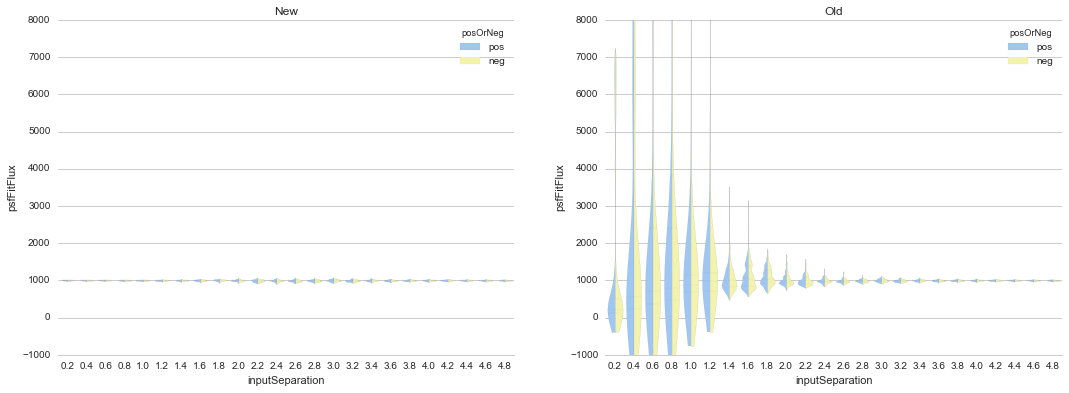

In [24]:
matplotlib.rcParams['figure.figsize'] = (18.0, 6.0)
fig, axes = plt.subplots(nrows=1, ncols=2)

df1 = pd.DataFrame([res['new'] for res in results])
df2 = df1.copy()
df1['psfFitFlux'] = df1.psfFitPosFlux   # positive
df1['posOrNeg'] = np.repeat('pos', df1.shape[0])
df2['psfFitFlux'] = -df2.psfFitNegFlux   # negative
df2['posOrNeg'] = np.repeat('neg', df2.shape[0])
sns.violinplot(x="inputSeparation", y="psfFitFlux", hue="posOrNeg", data=df1.append(df2), split=True,
               inner="quart", palette={"pos": "b", "neg": "y"}, cut=True, linewidth=0.1, bw=0.2, ax=axes[0])
sns.despine(left=True)

df1 = pd.DataFrame([res['old'] for res in results])
df2 = df1.copy()
df1['psfFitFlux'] = df1.psfFitPosFlux   # positive
df1['posOrNeg'] = np.repeat('pos', df1.shape[0])
df1.loc[(df1.psfFitFlux > 30000.), 'psfFitFlux'] = 30000.
df2['psfFitFlux'] = -df2.psfFitNegFlux   # negative
df2['posOrNeg'] = np.repeat('neg', df2.shape[0])
df2.loc[(df2.psfFitFlux > 30000.), 'psfFitFlux'] = 30000.
sns.violinplot(x="inputSeparation", y="psfFitFlux", hue="posOrNeg", data=df1.append(df2), split=True,
               inner="quart", palette={"pos": "b", "neg": "y"}, cut=True, linewidth=0.1, bw=0.2, ax=axes[1])
sns.despine(left=True)

axes[0].set_title('New')
axes[0].set_ylim([-1000,8000])
axes[1].set_title('Old')
axes[1].set_ylim([-1000,8000])

Try it again, this time setting different orientations as well. Next time we'll also test it as a function of scaling (source flux).

## Different orientations AND separations

In [25]:
varNames = genDipoleAndFitBothWays.__code__.co_varnames[:genDipoleAndFitBothWays.__code__.co_argcount]
varTuple = namedtuple("varTuple", varNames)

orientations = np.arange(0.0, 360.0, 36.0)
separations = np.arange(0.2, 5.0, 0.2)
n_reps = 10

inputs = [varTuple(w=51, h=51, xc=25., yc=25., psfSigma=2.0, separation=sep, rotAngle=rot, 
                    flux=1000., noise=1., tol=1e-3, rel_weight=0.1, 
                   verbose=False, display=False) 
          for i in xrange(n_reps) for rot in orientations for sep in separations]
print len(inputs)

def processInput(i):
    output = genDipoleAndFitBothWays(w=i.w, h=i.h, xc=i.xc, yc=i.yc, psfSigma=i.psfSigma, 
                                     separation=i.separation, rotAngle=i.rotAngle, flux=i.flux, 
                                     rel_weight=i.rel_weight, noise=i.noise, tol=i.tol, 
                                     verbose=False, display=False)
    if output['new'] is not None:
        output['new'] = output['new']._asdict()
    if output['old'] is not None:
        output['old'] = output['old']._asdict()
    return output

num_cores = multiprocessing.cpu_count() / 2
results2 = Parallel(n_jobs=num_cores)(delayed(processInput)(i) for i in inputs)
#results2 = [processInput(i) for i in inputs]

2400


(0, 5)

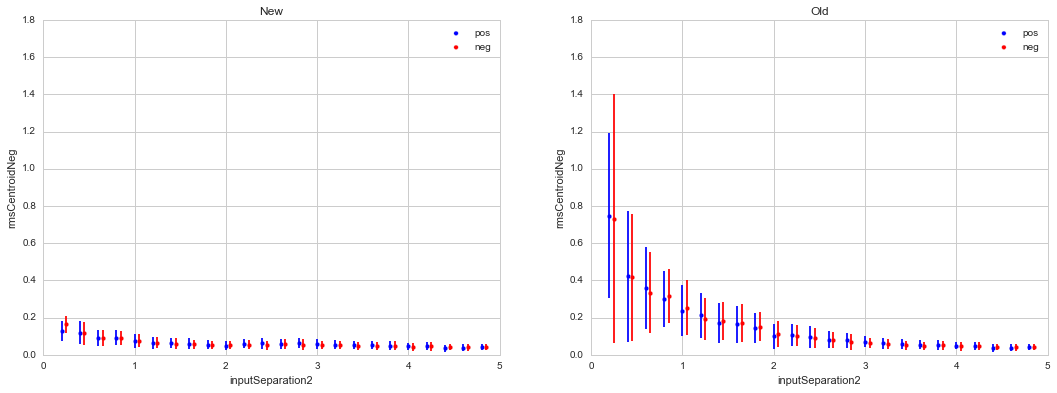

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=2)

df = pd.DataFrame([res['new'] for res in results2])
df['rmsCentroidPos'] = np.sqrt((df.inputPosCentroidX - df.psfFitPosCentroidX)**2. + \
                               (df.inputPosCentroidY - df.psfFitPosCentroidY)**2.)

df['rmsCentroidNeg'] = np.sqrt((df.inputNegCentroidX - df.psfFitNegCentroidX)**2. + \
                               (df.inputNegCentroidY - df.psfFitNegCentroidY)**2.)
df['inputSeparation2'] = df.inputSeparation + 0.05
tmp_df = df.groupby('inputSeparation').median()
tmp_df['inputSeparation'] = tmp_df.index.values
tmp_df2 = df.groupby('inputSeparation').mad() * 1.
ax = tmp_df.plot(x='inputSeparation', y='rmsCentroidPos', kind='scatter', yerr=tmp_df2['rmsCentroidPos'], color='blue', label='pos', ax=axes[0])
tmp_df.plot(x='inputSeparation2', y='rmsCentroidNeg', kind='scatter', yerr=tmp_df2['rmsCentroidNeg'], color='red', label='neg', ax=ax)

df = pd.DataFrame([res['old'] for res in results2])
df['rmsCentroidPos'] = np.sqrt((df.inputPosCentroidX - df.psfFitPosCentroidX)**2. + \
                               (df.inputPosCentroidY - df.psfFitPosCentroidY)**2.)
df['rmsCentroidNeg'] = np.sqrt((df.inputNegCentroidX - df.psfFitNegCentroidX)**2. + \
                               (df.inputNegCentroidY - df.psfFitNegCentroidY)**2.)
df['inputSeparation2'] = df.inputSeparation + 0.05
tmp_df = df.groupby('inputSeparation').median()
tmp_df['inputSeparation'] = tmp_df.index.values
tmp_df2 = df.groupby('inputSeparation').mad() * 1.
ax = tmp_df.plot(x='inputSeparation', y='rmsCentroidPos', kind='scatter', yerr=tmp_df2['rmsCentroidPos'], color='blue', label='pos', ax=axes[1])
tmp_df.plot(x='inputSeparation2', y='rmsCentroidNeg', kind='scatter', yerr=tmp_df2['rmsCentroidNeg'], color='red', label='neg', ax=ax)

axes[0].set_title('New')
axes[0].set_ylim([0.,1.8]); axes[0].set_xlim([0, 5])
axes[1].set_title('Old')
axes[1].set_ylim([0.,1.8]); axes[1].set_xlim([0, 5])

(-0.1, 2.0)

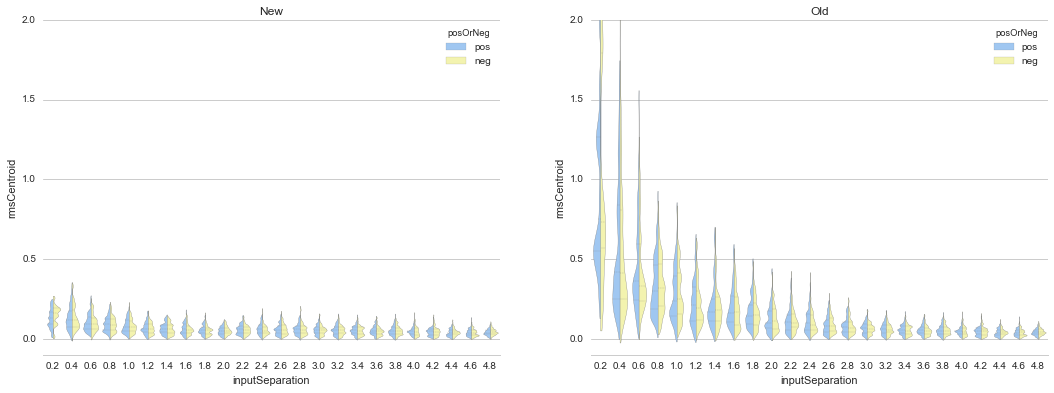

In [27]:
matplotlib.rcParams['figure.figsize'] = (18.0, 6.0)
fig, axes = plt.subplots(nrows=1, ncols=2)

df1 = pd.DataFrame([res['new'] for res in results2])
df2 = df1.copy()
df1['rmsCentroid'] = np.sqrt((df1.inputPosCentroidX - df1.psfFitPosCentroidX)**2. + \
                               (df1.inputPosCentroidY - df1.psfFitPosCentroidY)**2.)   # positive
df1['posOrNeg'] = np.repeat('pos', df1.shape[0])
df2['rmsCentroid'] = np.sqrt((df2.inputNegCentroidX - df2.psfFitNegCentroidX)**2. + \
                               (df2.inputNegCentroidY - df2.psfFitNegCentroidY)**2.)   # negative
df2['posOrNeg'] = np.repeat('neg', df2.shape[0])
sns.violinplot(x="inputSeparation", y="rmsCentroid", hue="posOrNeg", data=df1.append(df2), split=True,
               inner="quart", palette={"pos": "b", "neg": "y"}, cut=True, linewidth=0.3, bw=0.2, ax=axes[0])
sns.despine(left=True)

df1 = pd.DataFrame([res['old'] for res in results2])
df2 = df1.copy()
df1['rmsCentroid'] = np.sqrt((df1.inputPosCentroidX - df1.psfFitPosCentroidX)**2. + \
                               (df1.inputPosCentroidY - df1.psfFitPosCentroidY)**2.)   # positive
df1['posOrNeg'] = np.repeat('pos', df1.shape[0])
df2['rmsCentroid'] = np.sqrt((df2.inputNegCentroidX - df2.psfFitNegCentroidX)**2. + \
                               (df2.inputNegCentroidY - df2.psfFitNegCentroidY)**2.)   # negative
df2['posOrNeg'] = np.repeat('neg', df2.shape[0])
sns.violinplot(x="inputSeparation", y="rmsCentroid", hue="posOrNeg", data=df1.append(df2), split=True,
               inner="quart", palette={"pos": "b", "neg": "y"}, cut=True, linewidth=0.3, bw=0.2, ax=axes[1])
sns.despine(left=True)

axes[0].set_title('New')
axes[0].set_ylim([-0.1,2.0])
axes[1].set_title('Old')
axes[1].set_ylim([-0.1,2.0])

(-1000, 8000)

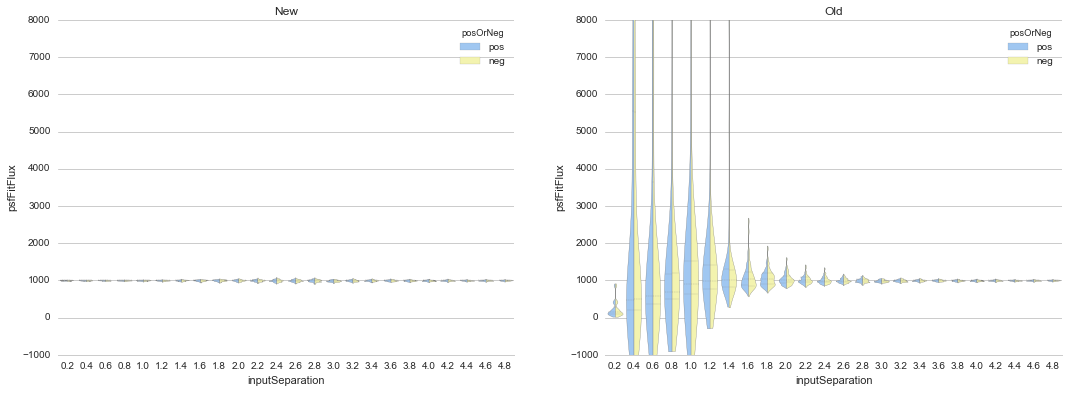

In [28]:
matplotlib.rcParams['figure.figsize'] = (18.0, 6.0)
fig, axes = plt.subplots(nrows=1, ncols=2)

df1 = pd.DataFrame([res['new'] for res in results2])
df2 = df1.copy()
df1['psfFitFlux'] = df1.psfFitPosFlux   # positive
df1['posOrNeg'] = np.repeat('pos', df1.shape[0])
df2['psfFitFlux'] = -df2.psfFitNegFlux   # negative
df2['posOrNeg'] = np.repeat('neg', df2.shape[0])
sns.violinplot(x="inputSeparation", y="psfFitFlux", hue="posOrNeg", data=df1.append(df2), split=True,
               inner="quart", palette={"pos": "b", "neg": "y"}, cut=True, linewidth=0.3, bw=0.2, ax=axes[0])
sns.despine(left=True)

df1 = pd.DataFrame([res['old'] for res in results2])
df2 = df1.copy()
df1['psfFitFlux'] = df1.psfFitPosFlux   # positive
df1['posOrNeg'] = np.repeat('pos', df1.shape[0])
df1.loc[(df1.psfFitFlux > 30000.), 'psfFitFlux'] = 30000.
df2['psfFitFlux'] = -df2.psfFitNegFlux   # negative
df2['posOrNeg'] = np.repeat('neg', df2.shape[0])
df2.loc[(df2.psfFitFlux > 30000.), 'psfFitFlux'] = 30000.
sns.violinplot(x="inputSeparation", y="psfFitFlux", hue="posOrNeg", data=df1.append(df2), split=True,
               inner="quart", palette={"pos": "b", "neg": "y"}, cut=True, linewidth=0.3, bw=0.2, ax=axes[1])
sns.despine(left=True)

axes[0].set_title('New')
axes[0].set_ylim([-1000,8000])
axes[1].set_title('Old')
axes[1].set_ylim([-1000,8000])

## Different dipole fluxes (signal-to-noise) AND orientations AND separations

In [30]:
varNames = genDipoleAndFitBothWays.__code__.co_varnames[:genDipoleAndFitBothWays.__code__.co_argcount]
varTuple = namedtuple("varTuple", varNames)

orientations = np.arange(0.0, 360.0, 36.0)
separations = np.arange(0.2, 5.0, 0.2)
fluxes = np.arange(250., 6000., 250.)
n_reps = 2 ## if I do more than 2 the code doesn't seem to want to exit the cell, even after it completes.

inputs = [varTuple(w=51, h=51, xc=25., yc=25., psfSigma=2.0, separation=sep, rotAngle=rot, 
                    flux=flux, noise=1., tol=1e-3, rel_weight=0.1, verbose=False, 
                   display=False) 
                for i in xrange(n_reps) for flux in fluxes for rot in orientations for sep in separations]
print len(inputs)

def processInput(i):
    output = genDipoleAndFitBothWays(w=i.w, h=i.h, xc=i.xc, yc=i.yc, psfSigma=i.psfSigma, 
                                     separation=i.separation, rotAngle=i.rotAngle, flux=i.flux, 
                                     noise=i.noise, tol=i.tol, rel_weight=i.rel_weight, 
                                     verbose=False, display=False)
    if output['new'] is not None:
        output['new'] = output['new']._asdict()
    if output['old'] is not None:
        output['old'] = output['old']._asdict()
    return output
 
num_cores = multiprocessing.cpu_count() / 2
#results3 = [processInput(i) for i in inputs]
results3 = Parallel(n_jobs=num_cores)(delayed(processInput)(i) for i in inputs)

11040


In [25]:
## NOT RUN:
if False:
    import cPickle as pickle
    import gzip
    pickle.dump((results, results2, results3), gzip.GzipFile("results_8.p.gz", "wb"))

(-0.05, 0.8)

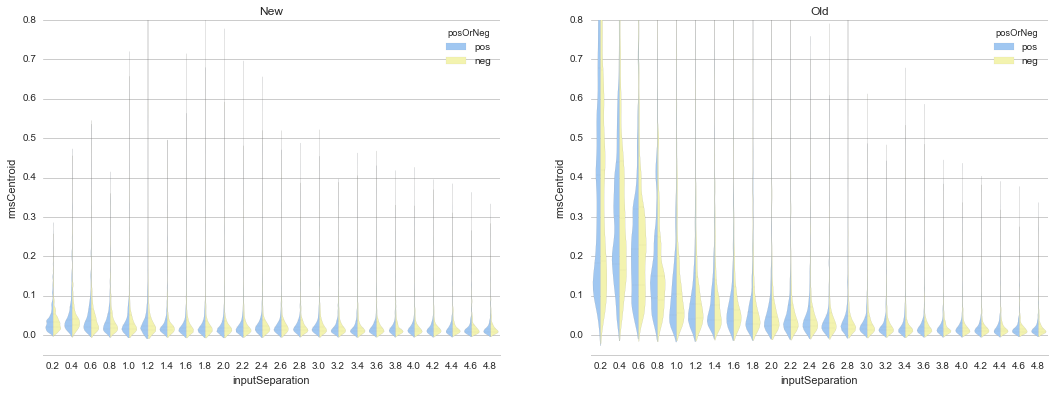

In [31]:
matplotlib.rcParams['figure.figsize'] = (18.0, 6.0)
fig, axes = plt.subplots(nrows=1, ncols=2)

df1 = pd.DataFrame([res['new'] for res in results3])
df2 = df1.copy()
df1['rmsCentroid'] = np.sqrt((df1.inputPosCentroidX - df1.psfFitPosCentroidX)**2. + \
                               (df1.inputPosCentroidY - df1.psfFitPosCentroidY)**2.)   # positive
df1['posOrNeg'] = np.repeat('pos', df1.shape[0])
df2['rmsCentroid'] = np.sqrt((df2.inputNegCentroidX - df2.psfFitNegCentroidX)**2. + \
                               (df2.inputNegCentroidY - df2.psfFitNegCentroidY)**2.)   # negative
df2['posOrNeg'] = np.repeat('neg', df2.shape[0])
sns.violinplot(x="inputSeparation", y="rmsCentroid", hue="posOrNeg", data=df1.append(df2), split=True,
               inner="quart", palette={"pos": "b", "neg": "y"}, cut=True, linewidth=0.1, bw=0.1, ax=axes[0])
sns.despine(left=True)

df1 = pd.DataFrame([res['old'] for res in results3])
df2 = df1.copy()
df1['rmsCentroid'] = np.sqrt((df1.inputPosCentroidX - df1.psfFitPosCentroidX)**2. + \
                               (df1.inputPosCentroidY - df1.psfFitPosCentroidY)**2.)   # positive
df1['posOrNeg'] = np.repeat('pos', df1.shape[0])
df2['rmsCentroid'] = np.sqrt((df2.inputNegCentroidX - df2.psfFitNegCentroidX)**2. + \
                               (df2.inputNegCentroidY - df2.psfFitNegCentroidY)**2.)   # negative
df2['posOrNeg'] = np.repeat('neg', df2.shape[0])
sns.violinplot(x="inputSeparation", y="rmsCentroid", hue="posOrNeg", data=df1.append(df2), split=True,
               inner="quart", palette={"pos": "b", "neg": "y"}, cut=True, linewidth=0.1, bw=0.1, ax=axes[1])
sns.despine(left=True)

axes[0].set_title('New')
axes[0].set_ylim([-0.05,0.8])
axes[1].set_title('Old')
axes[1].set_ylim([-0.05,0.8])

(-1000, 15000)

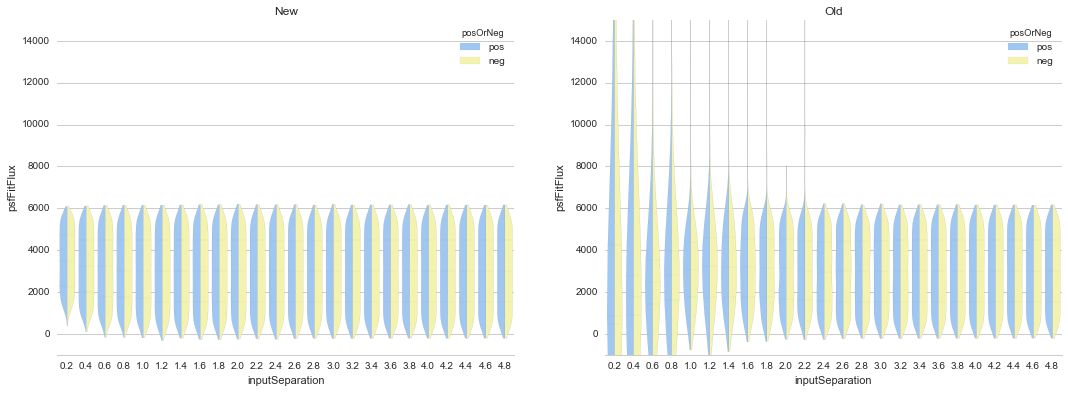

In [32]:
##### matplotlib.rcParams['figure.figsize'] = (18.0, 6.0)
fig, axes = plt.subplots(nrows=1, ncols=2)

df1 = pd.DataFrame([res['new'] for res in results3])
#df1 = df1.loc[(df1.inputFlux == 5000.)]
df2 = df1.copy()
df1['psfFitFlux'] = df1.psfFitPosFlux   # positive
df1['posOrNeg'] = np.repeat('pos', df1.shape[0])
df2['psfFitFlux'] = -df2.psfFitNegFlux   # negative
df2['posOrNeg'] = np.repeat('neg', df2.shape[0])
sns.violinplot(x="inputSeparation", y="psfFitFlux", hue="posOrNeg", data=df1.append(df2), split=True,
               inner="quart", palette={"pos": "b", "neg": "y"}, cut=True, bw=0.25, linewidth=0.1, ax=axes[0])
sns.despine(left=True)

df1 = pd.DataFrame([res['old'] for res in results3])
#df1 = df1.loc[(df1.inputFlux == 5000.)]
df2 = df1.copy()
df1['psfFitFlux'] = df1.psfFitPosFlux   # positive
#df1.loc[(df1.psfFitFlux > 30000.), 'psfFitFlux'] = 30000.
df1['posOrNeg'] = np.repeat('pos', df1.shape[0])
df2['psfFitFlux'] = -df2.psfFitNegFlux   # negative
#df2.loc[(df2.psfFitFlux > 30000.), 'psfFitFlux'] = 30000.
df2['posOrNeg'] = np.repeat('neg', df2.shape[0])
sns.violinplot(x="inputSeparation", y="psfFitFlux", hue="posOrNeg", data=df1.append(df2), split=True,
               inner="quart", palette={"pos": "b", "neg": "y"}, cut=True, bw=0.25, linewidth=0.1, ax=axes[1])
sns.despine(left=True)

axes[0].set_title('New')
axes[0].set_ylim([-1000,15000])
axes[1].set_title('Old')
axes[1].set_ylim([-1000,15000])

(0, 7000)

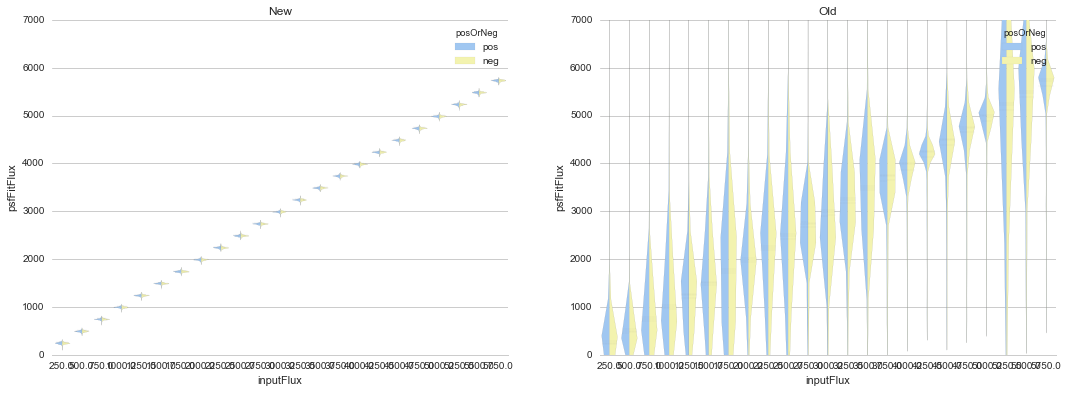

In [33]:
matplotlib.rcParams['figure.figsize'] = (18.0, 6.0)
fig, axes = plt.subplots(nrows=1, ncols=2)

df1 = pd.DataFrame([res['new'] for res in results3])
df2 = df1.copy()
df1['psfFitFlux'] = df1.psfFitPosFlux   # positive
df1['posOrNeg'] = np.repeat('pos', df1.shape[0])
df2['psfFitFlux'] = -df2.psfFitNegFlux   # negative
df2['posOrNeg'] = np.repeat('neg', df2.shape[0])
sns.violinplot(x="inputFlux", y="psfFitFlux", hue="posOrNeg", data=df1.append(df2), split=True,
               inner="quart", palette={"pos": "b", "neg": "y"}, cut=True, bw=0.1, linewidth=0.1, ax=axes[0])
sns.despine(left=True)

df1 = pd.DataFrame([res['old'] for res in results3])
df2 = df1.copy()
df1['psfFitFlux'] = df1.psfFitPosFlux   # positive
#df1.loc[(df1.psfFitFlux > 30000.), 'psfFitFlux'] = 30000.
df1['posOrNeg'] = np.repeat('pos', df1.shape[0])
df2['psfFitFlux'] = -df2.psfFitNegFlux   # negative
#df2.loc[(df2.psfFitFlux > 30000.), 'psfFitFlux'] = 30000.
df2['posOrNeg'] = np.repeat('neg', df2.shape[0])
sns.violinplot(x="inputFlux", y="psfFitFlux", hue="posOrNeg", data=df1.append(df2), split=True,
               inner="quart", palette={"pos": "b", "neg": "y"}, cut=True, bw=0.1, linewidth=0.1, ax=axes[1])
sns.despine(left=True)

axes[0].set_title('New')
axes[0].set_ylim([0,7000])
axes[1].set_title('Old')
axes[1].set_ylim([0,7000])

(-100, 6500)

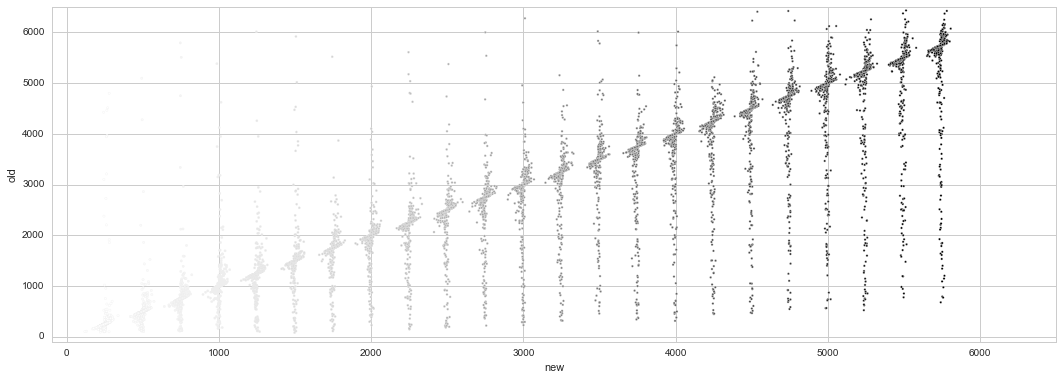

In [34]:
df1 = pd.DataFrame([res['new'] for res in results3])
df2 = pd.DataFrame([res['old'] for res in results3])
df = pd.DataFrame({'new': df1['psfFitPosFlux'], 'old': df2['psfFitPosFlux'], 'fl': df1['inputFlux']})
df = df[(df['new'] != np.inf) & (df['old'] != np.inf)] # & (df['sn1'] < 30000.) & (df['sn2'] < 30000.)]
ax = df.plot(x='new', y='old', kind='scatter', c=df['fl']/df['fl'].max(), s=5.)
ax.set_xlim([-100,6500])
ax.set_ylim([-100,6500])

(-0.5, 3.0)

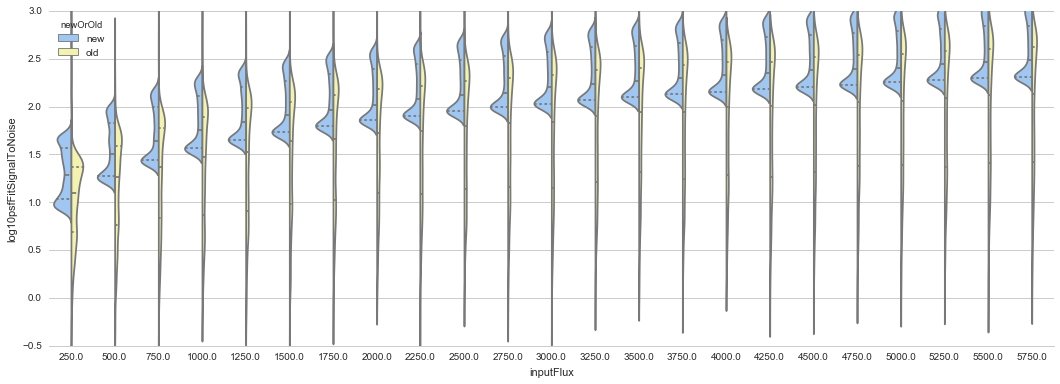

In [35]:
df = pd.DataFrame([res['new'] for res in results3])
df['newOrOld'] = np.repeat('new', df.shape[0])
df['log10psfFitSignalToNoise'] = np.log10(df['psfFitSignaltoNoise'])
df = df[(df.log10psfFitSignalToNoise != np.inf) & (df.log10psfFitSignalToNoise != np.nan) & (df.log10psfFitSignalToNoise < 8000.)]

df2 = pd.DataFrame([res['old'] for res in results3])
df2['newOrOld'] = np.repeat('old', df2.shape[0])
df2['log10psfFitSignalToNoise'] = np.log10(df2['psfFitSignaltoNoise'])
df2 = df2[(np.abs(df2.log10psfFitSignalToNoise) != np.inf) & (df2.log10psfFitSignalToNoise != np.nan) & (df2.log10psfFitSignalToNoise < 8000.)]

df = df.append(df2)

matplotlib.rcParams['figure.figsize'] = (18.0, 6.0)
#fig, axes = plt.subplots(nrows=1, ncols=2)
fig = plt.figure()
ax = fig.add_subplot(111)

sns.violinplot(x="inputFlux", y="log10psfFitSignalToNoise", hue="newOrOld", data=df, split=True,
               inner="quart", palette={"new": "b", "old": "y"}, cutoff=True, bw=0.2, axis=ax)
sns.despine(left=True)
ax.set_ylim([-0.5,3.])

## Investigate error contours by including (or not) the pre-subtracted image planes in the fit

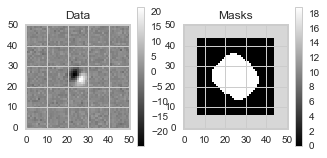

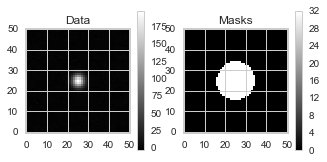

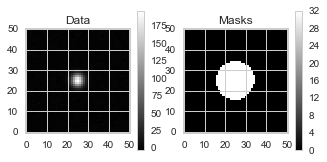

In [41]:
xc=25.; yc=25.; separation=0.4; rotAngle=324.

rotAngRad = rotAngle / 180. * np.pi
sep = separation / 2.
xcenPos, ycenPos = xc+sep*np.cos(rotAngRad), yc+sep*np.sin(rotAngRad)
xcenNeg, ycenNeg = xc-sep*np.cos(rotAngRad), yc-sep*np.sin(rotAngRad)

dipole, (posImage, posCatalog), (negImage, negCatalog) = \
    makeDipoleImage_lsst(w=51, h=51, xcenPos=xcenPos, ycenPos=ycenPos, \
                         xcenNeg=xcenNeg, ycenNeg=ycenNeg, \
                         psfSigma=2., flux=5000., noise=1.)

displayImage(dipole)
displayImage(posImage)
displayImage(negImage)
s = detectDipoleSources(dipole, verbose=False)
_, result0 = fitDipole_new((dipole, posImage, negImage), s, tol=1e-7, rel_weight=0.0,
                           verbose=False, display=False, return_fitObj=True)
_, result1 = fitDipole_new((dipole, posImage, negImage), s, tol=1e-3, rel_weight=0.05, 
                           verbose=False, display=False, return_fitObj=True)

### Plot confidence intervals...

see https://lmfit.github.io/lmfit-py/confidence.html

First, don't include pre-subtracted data (weight=0)

            95.00%    68.00%    _BEST_    68.00%    95.00%
 xcenPos:  -0.15701  -0.07642  25.49331  +0.08368  +0.14765
 ycenPos:  -0.11281  -0.06248  24.53354  +0.05699  +0.11738
 xcenNeg:  -0.14458  -0.08181  24.36802  +0.07481  +0.15139
 ycenNeg:  -0.12010  -0.05762  25.35843  +0.06331  +0.11284
 flux   :-274.33549-170.609321445.50880+207.70407+508.16178
 fluxNeg:-274.37241-170.596321474.51558+207.54840+507.84955


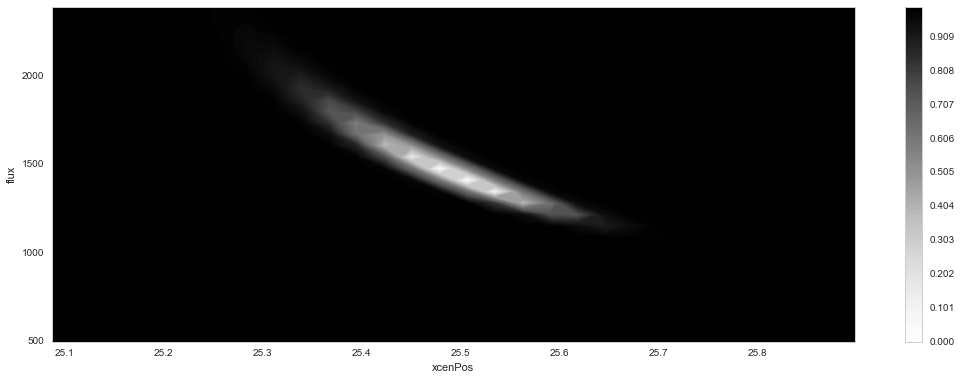

In [42]:
## hide warnings for this fit.
import warnings
warnings.filterwarnings('ignore')

ci, trace = lmfit.conf_interval(result0, result0, sigmas=[0.68,0.95],
                                trace=True, verbose=False)
lmfit.printfuncs.report_ci(ci)

cx, cy, grid = lmfit.conf_interval2d(result0, result0, 'xcenPos','flux', 30, 30)
plt.contourf(cx, cy, grid, np.linspace(0,1,100))
plt.xlabel('xcenPos')
plt.ylabel('flux')
plt.colorbar()

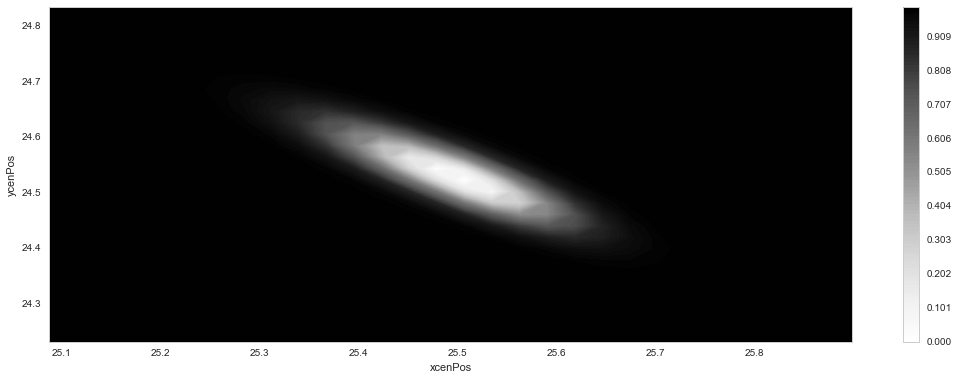

In [46]:
cx, cy, grid = lmfit.conf_interval2d(result0, result0, 'xcenPos','ycenPos', 30, 30)
plt.contourf(cx, cy, grid, np.linspace(0,1,100))
plt.xlabel('xcenPos')
plt.ylabel('ycenPos')
plt.colorbar()

Now, with the pre-subtraction data weighted at 5% of the subtracted data:

            95.00%    68.00%    _BEST_    68.00%    95.00%
 xcenPos:  -0.03859  -0.01957  25.09450  +0.01957  +0.04016
 ycenPos:  -0.04537  -0.02269  24.82948  +0.02331  +0.04427
 xcenNeg:  -0.03929  -0.02046  24.76906  +0.01923  +0.03988
 ycenNeg:  -0.04476  -0.02324  25.06697  +0.02249  +0.04477
 flux   :-161.29790 -81.862384966.33404 +82.05732+161.53585
 fluxNeg:-161.26739 -81.862144993.74087 +82.03439+161.49181


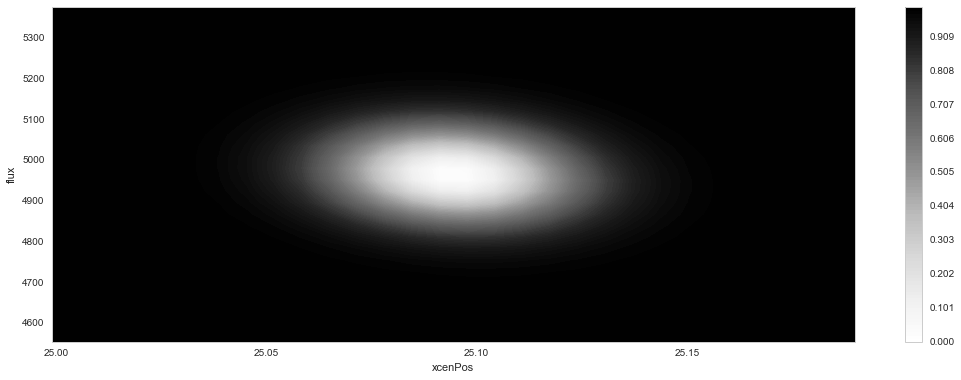

In [44]:
ci, trace = lmfit.conf_interval(result1, result1, sigmas=[0.68,0.95],
                                trace=True, verbose=False)
lmfit.printfuncs.report_ci(ci)

cx, cy, grid = lmfit.conf_interval2d(result1, result1, 'xcenPos','flux', 30, 30)
plt.contourf(cx, cy, grid, np.linspace(0,1,100))
plt.xlabel('xcenPos')
plt.ylabel('flux')
plt.colorbar()

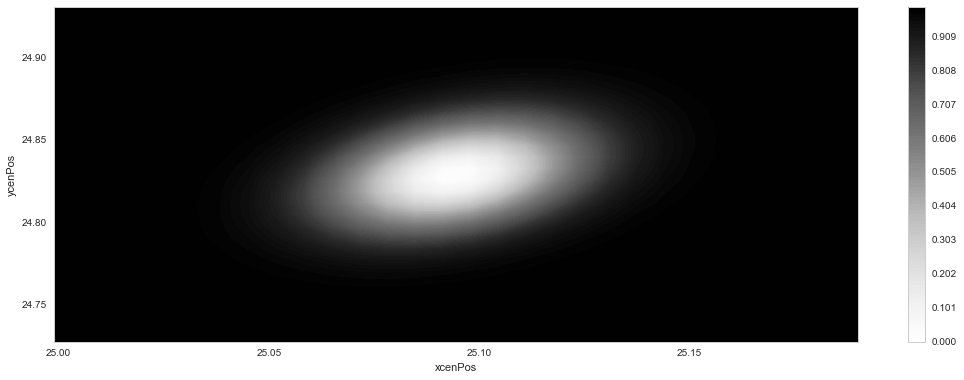

In [47]:
cx, cy, grid = lmfit.conf_interval2d(result1, result1, 'xcenPos','ycenPos', 30, 30)
plt.contourf(cx, cy, grid, np.linspace(0,1,100))
plt.xlabel('xcenPos')
plt.ylabel('ycenPos')
plt.colorbar()